# Explore spatial averaging for horizontal Yagi antenna

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 7/6/2022

+ FEKO data provided by Danie Ludick
+ Uses **v10** RFcalcUC module
+ This notebook uses dataframes in HDF5 files that were generated from the `make_HDF5_HYagi.ipynb` notebook

## Load necessary python modules

In [1]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

# import other modules
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from tqdm import tqdm
from scipy import stats
from scipy import interpolate
from collections import namedtuple
import textwrap as tr
import pandas as pd
import RFcalcUC_v10 as RFcalcUC
from matplotlib.ticker import StrMethodFormatter
pd.set_option('display.max_rows', 180)
from icecream import ic

# Set plotting environment
sn.set()

## Look at model metadata for the spatial averaging trials

In [2]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials

,unit,1,2,3
INPUT,,,,
fMHz,MHz,900,900,900
antenna,,IEC 62232 panel antenna,IEC 62232 panel antenna,Yagi
Prad,W,80,200,100
coordinate_origin,,centre of the middle feed segment,centre of the middle feed segment,centre of rear reflector
xstart,m,0.5,-1,-1
xend,m,14,14,5
dx,m,0.1,0.1,0.1
ystart,m,-7,-7,-2
yend,m,7,7,2


## Create the RFc object for the analyses
The class for this object is in the `RFcalcUC_v8.py` file

In [3]:
# Set trial number
trial = 3
t = trials[str(trial)]

In [4]:
# Set data and plot folders
datadir = f'../antennas/{t.antenna_folder}/data/'
plotdir = f'../antennas/{t.antenna_folder}/plots/'
print(f'{datadir = }')
print(f'{plotdir = }')

# Specify the RFc object parameters
freq = t.fMHz   # 900 MHz
power = t.Prad  # 80 W

# Field point grid
grid = dict(x=[t.xstart, t.xend, t.dx], 
            y=[t.ystart, t.yend, t.dy],
            z=[t.zstart, t.zend, t.dz])

# Antenna box dimensions (xyz extents)
xb = [-0.04, 0]
yb = [-0.15, 0.15]
zb = [-1.125, 1.125]
antennabox = [xb, yb, zb]

# Create the RFc object
reload(RFcalcUC)
R = RFcalcUC.RFc(freq, power, grid, antennabox)
R

datadir = '../antennas/Hyagi/data/'
plotdir = '../antennas/Hyagi/plots/'


Object parameters:
  900 MHz, 100 W
  errtol = 0.15
  offset = 0.01 m
  152,561 grid points
  nx = 61, ny = 41, nz = 61

In [5]:
# Import the S data files for FEKO and IXUS
Sfile = datadir + f'{t.antenna_folder}.hdf5'
R.importS(Sfile)

# Display the first few records in the S dataframe
display(R.S.head())

# Print the datatitles for the S data
display(R.datatitles)
print(*R.grid.items(),sep='\n')

Sfile='../antennas/Hyagi/data/Hyagi.hdf5'


,SE,SH,Smax,SARwbi
0,0.161726,0.161659,0.161726,NaN
1,0.165805,0.165718,0.165805,NaN
2,0.169610,0.169503,0.169610,NaN
3,0.173072,0.172948,0.173072,NaN
4,0.176124,0.175984,0.176124,NaN


col = 'SE'
col = 'SH'
col = 'Smax'
col = 'SARwbi'


,x,y,z,r,phi,SE,SH,Smax,SARwbi
0,-1.0,-2.0,-3.0,2.236068,-116.565051,0.161726,0.161659,0.161726,NaN
1,-1.0,-2.0,-2.9,2.236068,-116.565051,0.165805,0.165718,0.165805,NaN
2,-1.0,-2.0,-2.8,2.236068,-116.565051,0.169610,0.169503,0.169610,NaN
3,-1.0,-2.0,-2.7,2.236068,-116.565051,0.173072,0.172948,0.173072,NaN
4,-1.0,-2.0,-2.6,2.236068,-116.565051,0.176124,0.175984,0.176124,NaN


{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)'}

('x', [-1, 5, 0.1])
('y', [-2, 2, 0.1])
('z', [-3, 3, 0.1])


## Data checks

### Show S and SAR grids

In [6]:
R.S.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152561 entries, 0 to 152560
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       152561 non-null  float64
 1   y       152561 non-null  float64
 2   z       152561 non-null  float64
 3   r       152561 non-null  float64
 4   phi     152561 non-null  float64
 5   SE      152561 non-null  float64
 6   SH      152561 non-null  float64
 7   Smax    152561 non-null  float64
 8   SARwbi  102541 non-null  float64
dtypes: float64(9)
memory usage: 10.5 MB


In [7]:
RFcalcUC.show_grid_points(R.S, fields=['SARwbi'], hman=None,axv=(True,True,False))

### View public and occ compliance zones

In [9]:
# 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.ExclusionZone(
    data=["Smax", "Smax"],
    power=[100, 100],
    color=["gold", "red"],
    alpha=[0.5, 0.8],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    title="RPS S-1 public and occupational exclusion zones for FEKO Smax data",
    ycut=0,
    figsize=(1200,800)
)

dat='Smax', con=4.5
dat='Smax', con=22.5
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500
power=100, plotpower=100, setting=occupational, limit=22.5 W/m², contour level=22.500


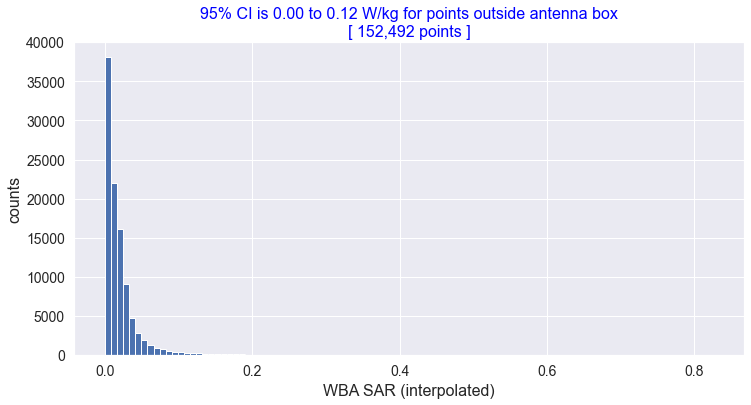

In [10]:
R.hist(data='SARwbi', bins=100)

## Create spatially averaged fields
Create some new S columns for vertical spatial averaging

**c** is the convolution vector applied to z columns of points for each (x,y) group

In [11]:
def conv_vector(l, dl, m):
    '''Create a convolution vector
        l = length of convolution vector (m)
       dl = increment spacing between points in convolution vector (m)
        m = number of averaging points in convolution vector'''

    n = int(round(l/dl)) + 1  # number of points in convolution vector'''
    c = np.ones(n)            # convolution vector
    ix = np.arange(n)         # index of convolution vector
    dix = (n-1)/(m-1)         # index spacing between convolution averaging points

    assert round(l/dl,0) == round(l/dl,1), f'dl ({dl}) does not divide equally into l ({l})'
    assert type(m) == int, f'm ({m}) must be an integer'
    assert (n-1) % (m-1) == 0, f'm ({m}) does not distribute evenly across number of convolution points ({n})'

    c[(ix % dix) != 0] = 0
    c = c/m

    assert np.isclose(sum(c), 1, rtol=1e-08), f'sum of c ({sum(c)}) does not add up to 1'
    
    return c

In [12]:
# 1.6m vertical average curves
l, dl = 1.6, 0.1
for m in [17,5,3]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")  


17 points: sum[0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059] = 1.0
creating SE-1.6m-17 spatial average of SE
creating Smax-1.6m-17 spatial average of Smax

 5 points: sum[0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2] = 1.0
creating SE-1.6m-5 spatial average of SE
creating Smax-1.6m-5 spatial average of Smax

 3 points: sum[0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333] = 1.0
creating SE-1.6m-3 spatial average of SE
creating Smax-1.6m-3 spatial average of Smax


In [13]:
# 1.5m vertical average curves
l, dl = 1.5, 0.1
for m in [4,6,16]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")  


 4 points: sum[0.25, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.25] = 1.0
creating SE-1.5m-4 spatial average of SE
creating Smax-1.5m-4 spatial average of Smax

 6 points: sum[0.167, 0.0, 0.0, 0.167, 0.0, 0.0, 0.167, 0.0, 0.0, 0.167, 0.0, 0.0, 0.167, 0.0, 0.0, 0.167] = 0.9999999999999999
creating SE-1.5m-6 spatial average of SE
creating Smax-1.5m-6 spatial average of Smax

16 points: sum[0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062] = 1.0
creating SE-1.5m-16 spatial average of SE
creating Smax-1.5m-16 spatial average of Smax


In [14]:
# 2m vertical average curves
l, dl = 2, 0.1
for m in [21]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")  


21 points: sum[0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048] = 1.0000000000000004
creating SE-2m-21 spatial average of SE
creating Smax-2m-21 spatial average of Smax


In [15]:
# 1.4m vertical average curves
l, dl = 1.4, 0.1
for m in [8,15]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")  


 8 points: sum[0.125, 0.0, 0.125, 0.0, 0.125, 0.0, 0.125, 0.0, 0.125, 0.0, 0.125, 0.0, 0.125, 0.0, 0.125] = 1.0
creating SE-1.4m-8 spatial average of SE
creating Smax-1.4m-8 spatial average of Smax

15 points: sum[0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067] = 0.9999999999999999
creating SE-1.4m-15 spatial average of SE
creating Smax-1.4m-15 spatial average of Smax


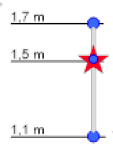

In [16]:
# IEC 62232 spatial averaging scheme (3pts over 1.7m)
c = np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1]) / 3
print(f'{len(c) = } points: sum{list(c.round(3))} = {sum(c)}')
R.spatavg(f"SE-IEC-1.7m-3", "SE", c, title=f"FEKO SE levels (IEC 3pt scheme over 1.7m)")
R.spatavg(f"Smax-IEC-1.7m-3", "Smax", c, title=f"FEKO Smax levels (IEC 3pt scheme over 1.7m)")

# IEC 62232 spatial averaging scheme (3pts over 0.6m)
c = np.array([1,0,0,0,1,0,1,0,0]) / 3
print(f'{len(c) = } points: sum{list(c.round(3))} = {sum(c)}')
R.spatavg(f"SE-IEC-0.6m-3", "SE", c, title=f"FEKO SE levels (IEC 3pt scheme over 0.6m)")
R.spatavg(f"Smax-IEC-0.6m-3", "Smax", c, title=f"FEKO Smax levels (IEC 3pt scheme over 0.6m)")

len(c) = 18 points: sum[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.333, 0.0, 0.333] = 1.0
creating SE-IEC-1.7m-3 spatial average of SE
creating Smax-IEC-1.7m-3 spatial average of Smax
len(c) = 9 points: sum[0.333, 0.0, 0.0, 0.0, 0.333, 0.0, 0.333, 0.0, 0.0] = 1.0
creating SE-IEC-0.6m-3 spatial average of SE
creating Smax-IEC-0.6m-3 spatial average of Smax


In [17]:
R.datatitles

{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)',
 'SE-1.6m-17': 'FEKO SE levels (17 points averaged over 1.6m)',
 'Smax-1.6m-17': 'FEKO Smax levels (17 points averaged over 1.6m)',
 'SE-1.6m-5': 'FEKO SE levels (5 points averaged over 1.6m)',
 'Smax-1.6m-5': 'FEKO Smax levels (5 points averaged over 1.6m)',
 'SE-1.6m-3': 'FEKO SE levels (3 points averaged over 1.6m)',
 'Smax-1.6m-3': 'FEKO Smax levels (3 points averaged over 1.6m)',
 'SE-1.5m-4': 'FEKO SE levels (4 points averaged over 1.5m)',
 'Smax-1.5m-4': 'FEKO Smax levels (4 points averaged over 1.5m)',
 'SE-1.5m-6': 'FEKO SE levels (6 points averaged over 1.5m)',
 'Smax-1.5m-6': 'FEKO Smax levels (6 points averaged over 1.5m)',
 'SE-1.5m-16': 'FEKO SE levels (16 points averaged over 1.5m)',
 'Smax-1.5m-16': 'FEKO Smax levels (16 points averaged over 1.5m)',
 'SE-2m-21': 'FEKO SE levels (21 points averaged over 2m)',
 'Smax-2

## Compare compliance zones

R essentially indicates the level of over-estimating WBA SAR compliance when conforming with the S limits. R ≥ 1 at an assessment point implies that WBA SAR will be compliant if S is compliant at that point and so it is desirable that R is always greater than or equal to 1.

#### WBA SAR vs all S settings

In [28]:
# Compare SAR, Smax
n = 6
R.ExclusionZone(
    data=["SARwbi","Smax","Smax-1.6m-17","Smax-1.6m-5","Smax-1.6m-3","Smax-IEC-0.6m-3"],
    power=[100] * n,
    color=["magenta","lightgrey","green","blue","brown","olive"],
    alpha=[1,0.5,0.5,0.5,0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs S compliance zones",
    ycut=0,
    axv=(False,False,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.08
dat='Smax', con=4.5
dat='Smax-1.6m-17', con=4.5
dat='Smax-1.6m-5', con=4.5
dat='Smax-1.6m-3', con=4.5
dat='Smax-IEC-0.6m-3', con=4.5
power=100, plotpower=100, setting=public, limit=0.08 W/kg, contour level=0.080
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500
power=100, plotpower=100, setting=public, limit=4.5 W/m², contour level=4.500


#### WBA SAR vs peak spatial Smax

In [19]:
# Compare SAR, Smax
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax"],
    power=[80] * n,
    color=["magenta","lightgrey"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.1
dat='Smax', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### Peak spatial Smax vs Smax spatial average 1.6m over 5 points

In [31]:
# Compare SAR, Smax
n = 2
R.ExclusionZone(
    data=["Smax-1.6m-5","Smax"],
    power=[50] * n,
    color=["blue","lightgrey"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Peak spatial Smax vs Smax spatial average 1.6m over 5 points",
    ycut=None,
    axv=(True,False,False),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-1.6m-5', con=9.0
dat='Smax', con=9.0
power=100, plotpower=50, setting=public, limit=4.5 W/m², contour level=9.000
power=100, plotpower=50, setting=public, limit=4.5 W/m², contour level=9.000


#### Peak spatial Smax vs Smax spatial average 1.6m over 17 points

In [40]:
# Compare SAR, Smax
n = 2
R.ExclusionZone(
    data=["Smax-1.6m-17","Smax"],
    power=[50] * n,
    color=["green","lightgrey"],
    alpha=[0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Peak spatial Smax vs Smax spatial average 1.6m over 17 points",
    ycut=None,
    axv=(True,False,False),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-1.6m-17', con=9.0
dat='Smax', con=9.0
power=100, plotpower=50, setting=public, limit=4.5 W/m², contour level=9.000
power=100, plotpower=50, setting=public, limit=4.5 W/m², contour level=9.000


#### WBA SAR vs Smax spatial average 1.6m over 17pts

In [25]:
# Compare SAR, Ssa 1.6m 17pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-17"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-17 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-17', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs Smax spatial average 1.6m over 5pts

In [44]:
# Compare SAR, Ssa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-5"],
    power=[50] * n,
    color=["magenta","blue"],
    alpha=[0.5, 0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-5 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.16
dat='Smax-1.6m-5', con=9.0
power=100, plotpower=50, setting=public, limit=0.08 W/kg, contour level=0.160
power=100, plotpower=50, setting=public, limit=4.5 W/m², contour level=9.000


#### WBA SAR vs Smax spatial average 1.6m over 3pts

In [22]:
# Compare SAR, Ssa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-3"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-3 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.1
dat='Smax-1.6m-3', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


#### WBA SAR vs SE spatial average 1.6m over 5pts

In [47]:
# Compare SAR, SEsa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","SE-1.6m-5"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs SE-1.6m-5 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='SE-1.6m-5', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### WBA SAR vs Smax IEC spatial average 0.6m over 3pts

In [23]:
# Compare SAR, SEsa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-IEC-0.6m-3"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-IEC-0.6m-3 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.1
dat='Smax-IEC-0.6m-3', con=5.625
power=100, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.100
power=100, plotpower=80, setting=public, limit=4.5 W/m², contour level=5.625


## Compliance ratio for SARwbi

### Generate compliance ratio statistic, R
$R$ is the ratio of the limit-normalized S exposure relative to the limit-normalized WBA SAR:

$\Large R = \frac{S/S_{lim}}{SAR_{wb}/SAR_{lim}}\; \; \; \; \; \; \; (Eq. 1)$

$R$ essentially indicates the level of over-estimating WBA SAR compliance when applying S limits.

Note that $R \geq 1 \Rightarrow$ WBA SAR is compliant if S is compliant

In [41]:
# Limits at 900 MHz
Slim = 4.5
SARlim = 0.08

# Create normalised errors for SARwbi
Slist = ['Smax','Smax-1.6m-17','Smax-1.6m-5','Smax-1.6m-3',
         'SE-1.6m-5','Smax-IEC-0.6m-3']

for Si in Slist:
    cr = (R.S[Si]/Slim) / (R.S.SARwbi/SARlim) 
    crname = f'{Si} SARwbi compliance ratio' 
    R.addS(cr, crname, f'Ratio of {Si} compliance to SARwbi compliance')

    dBcr = 10. * np.log10((R.S[Si]/Slim) / (R.S.SARwbi/SARlim))
    dBcrname = f'dB {Si} SARwbi compliance ratio' 
    R.addS(dBcr, dBcrname, f'dB Ratio of {Si} compliance to SARwbi compliance')

R.datatitles

{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)',
 'SE-1.6m-17': 'FEKO SE levels (17 points averaged over 1.6m)',
 'Smax-1.6m-17': 'FEKO Smax levels (17 points averaged over 1.6m)',
 'SE-1.6m-5': 'FEKO SE levels (5 points averaged over 1.6m)',
 'Smax-1.6m-5': 'FEKO Smax levels (5 points averaged over 1.6m)',
 'SE-1.6m-3': 'FEKO SE levels (3 points averaged over 1.6m)',
 'Smax-1.6m-3': 'FEKO Smax levels (3 points averaged over 1.6m)',
 'SE-1.5m-4': 'FEKO SE levels (4 points averaged over 1.5m)',
 'Smax-1.5m-4': 'FEKO Smax levels (4 points averaged over 1.5m)',
 'SE-1.5m-6': 'FEKO SE levels (6 points averaged over 1.5m)',
 'Smax-1.5m-6': 'FEKO Smax levels (6 points averaged over 1.5m)',
 'SE-1.5m-16': 'FEKO SE levels (16 points averaged over 1.5m)',
 'Smax-1.5m-16': 'FEKO Smax levels (16 points averaged over 1.5m)',
 'SE-2m-21': 'FEKO SE levels (21 points averaged over 2m)',
 'Smax-2

### R histograms

#### R histogram function

In [77]:
# Function to draw histograms of limit normalised ratios of Smax vs WBA SAR
def histR(Slist,dB=False,cols=2,mask=None):
    nS = len(Slist)
    rows = int(np.ceil(nS/cols))
    
    dts = [dt for dt in R.datatitles.keys() if 'compliance ratio' in dt]
    
    if dB:
        xlabel = 'dB(R)'
        cisuffix = ' dB'
        bins = np.linspace(-3,6,51)
        dtdicdB = {s:dt for s in Slist for dt in dts if s == dt.split()[1]}
        dtlist = [dtdicdB[s] for s in Slist]
    else:
        xlabel = 'R'
        cisuffix = ''
        bins = np.linspace(0,6,51)
        dtdic = {s:dt for s in Slist for dt in dts if s == dt.split()[0]}
        dtlist = [dtdic[s] for s in Slist]
        
    if type(mask) == type(None):
        df = R.S
    else:
        df = R.S[mask]

    fig, axes = plt.subplots(rows,cols,figsize=(10,14),sharey=True)
    axes = axes.flatten()

    for i, (s,dt) in enumerate(zip(Slist,dtlist)):        
        axes[i].hist(df[dt],bins=bins,density=True)
        axes[i].set_title(s, fontsize=15, color='g',fontweight="bold")
        axes[i].set_xlim(bins[0],bins[-1])
        ci = np.percentile(df[dt].dropna(),[2.5,97.5]).round(2)
        mean = df[dt].mean().round(2)
        text = f'95% CI = {ci[0]}, {ci[1]}{cisuffix}\n$\\mu$ = {mean}{cisuffix}' 
        text = f'95% CI = {ci[0]}, {ci[1]}{cisuffix}' 
        if i % 2 == 0:
            axes[i].set_ylabel('normalised counts',fontsize=14)
        if dB:
            axes[i].axvline(x=0, color='r',ls='--')
            axes[i].text(0.04, 0.9, text, horizontalalignment='left',
                         verticalalignment='center', transform=axes[i].transAxes,
                         fontsize=14, color='b')
        else:
            axes[i].axvline(x=1, color='r',ls='--')
            axes[i].text(0.96, 0.9, text, horizontalalignment='right',
                         verticalalignment='center', transform=axes[i].transAxes,
                         fontsize=14, color='b')

        axes[i].set_xlabel(xlabel, fontsize=14)

    # if nSa != rows * cols: axes[-1].remove()
    title = 'Limit normalised ratios of S vs WBA SAR:  $R = \\frac{S/S_{lim}}{SAR/SAR_{lim}}$\n'
    fig.suptitle(title, fontsize=20)
    fig.tight_layout(h_pad=1)

#### R histograms

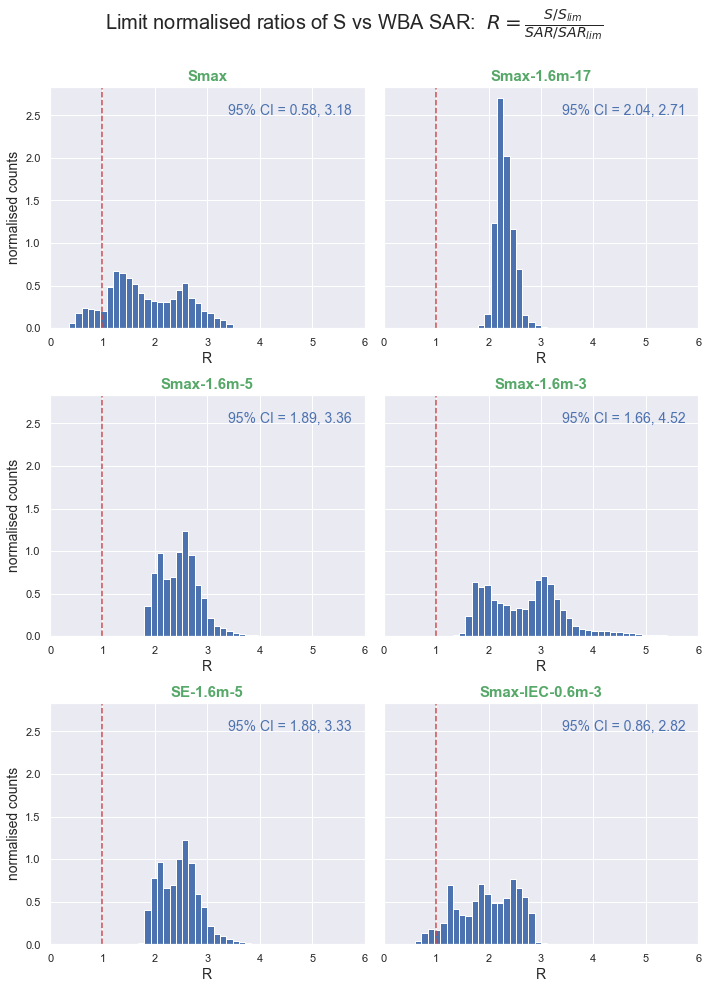

In [78]:
# R histograms for Slist
histR(Slist,dB=False,cols=2)
plt.savefig(plotdir + 'R histogram.png', dpi=150)

In [90]:
dtlist = [col for col in R.S.columns if "compliance" in col and "dB" not in col]
dfstats = R.S[dtlist].describe().T.round(2)
dfstats.to_excel(datadir + 'R descriptive stats.xlsx')
print(dfstats.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
      <th>mean</th>
      <th>std</th>
      <th>min</th>
      <th>25%</th>
      <th>50%</th>
      <th>75%</th>
      <th>max</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Smax SARwbi compliance ratio</th>
      <td>689579.0</td>
      <td>4.34</td>
      <td>761.27</td>
      <td>0.06</td>
      <td>1.29</td>
      <td>1.72</td>
      <td>2.46</td>
      <td>291921.39</td>
    </tr>
    <tr>
      <th>Smax-1.6m-17 SARwbi compliance ratio</th>
      <td>689579.0</td>
      <td>5.89</td>
      <td>524.28</td>
      <td>0.25</td>
      <td>2.19</td>
      <td>2.28</td>
      <td>2.41</td>
      <td>116966.09</td>
    </tr>
    <tr>
      <th>Smax-1.6m-5 SARwbi compliance ratio</th>
      <td>689579.0</td>
      <td>6.66</td>
      <td>764.51</td>
      <td>0.20</td>
      <td>2.16</td>
      <td>2.49</td>
      <td>2.71</td>
      <td>287983.05</td>
    </tr

In [80]:
# Get proportion of R < 1 values for Smax 
SmaxR = R.S['Smax SARwbi compliance ratio'].dropna()
nall = len(SmaxR)              # count of all not null R values
nlowR = len(SmaxR[SmaxR < 1])  # count of R values < 1
nlowR / nall

0.11796327904417044

In [81]:
def count(arr):
    return len(arr.dropna())

R.S[dtlist].agg([count,min,max,np.mean]).T

,count,min,max,mean
Smax SARwbi compliance ratio,689579.0,0.061375,291921.391424,4.341350
Smax-1.6m-17 SARwbi compliance ratio,689579.0,0.248629,116966.092721,5.889433
Smax-1.6m-5 SARwbi compliance ratio,689579.0,0.196901,287983.051595,6.656989
Smax-1.6m-3 SARwbi compliance ratio,689579.0,0.158372,479966.601840,7.681393
SE-1.6m-5 SARwbi compliance ratio,689579.0,0.146650,287983.051595,6.642622
Smax-IEC-0.6m-3 SARwbi compliance ratio,689579.0,0.088823,188925.561768,4.681848


#### dB(R) histograms

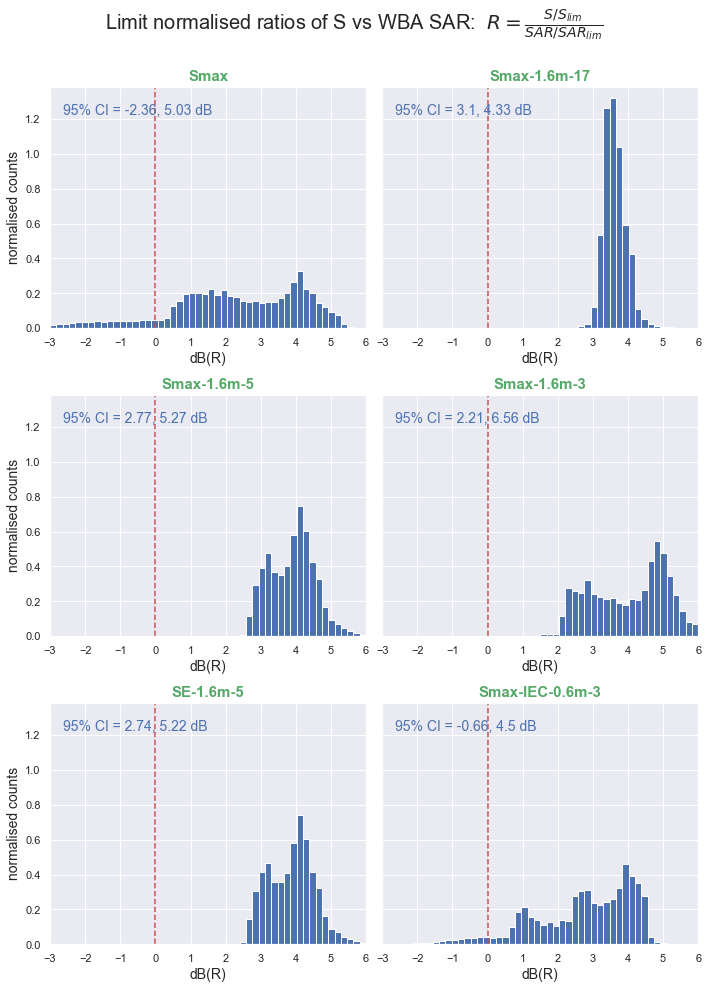

In [82]:
# R histograms for Slist
histR(Slist,dB=True,cols=2)
plt.savefig(plotdir + 'dB(R) histogram.png', dpi=150)

In [83]:
dBdtlist = [col for col in R.S.columns if "compliance" in col and "dB" in col]
R.S[dBdtlist].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
dB Smax SARwbi compliance ratio,689579.0,2.25,1.95,-12.12,1.09,2.36,3.91,54.65
dB Smax-1.6m-17 SARwbi compliance ratio,689579.0,3.63,0.51,-6.04,3.40,3.58,3.81,50.68
dB Smax-1.6m-5 SARwbi compliance ratio,689579.0,3.90,0.78,-7.06,3.34,3.96,4.33,54.59
dB Smax-1.6m-3 SARwbi compliance ratio,689579.0,4.17,1.26,-8.00,3.09,4.38,5.01,56.81
dB SE-1.6m-5 SARwbi compliance ratio,689579.0,3.88,0.77,-8.34,3.32,3.94,4.32,54.59
dB Smax-IEC-0.6m-3 SARwbi compliance ratio,689579.0,2.73,1.45,-10.51,1.77,2.99,3.91,52.76


#### R histograms with outant box filter
distance offset of $2\lambda$ from surface of antenna box

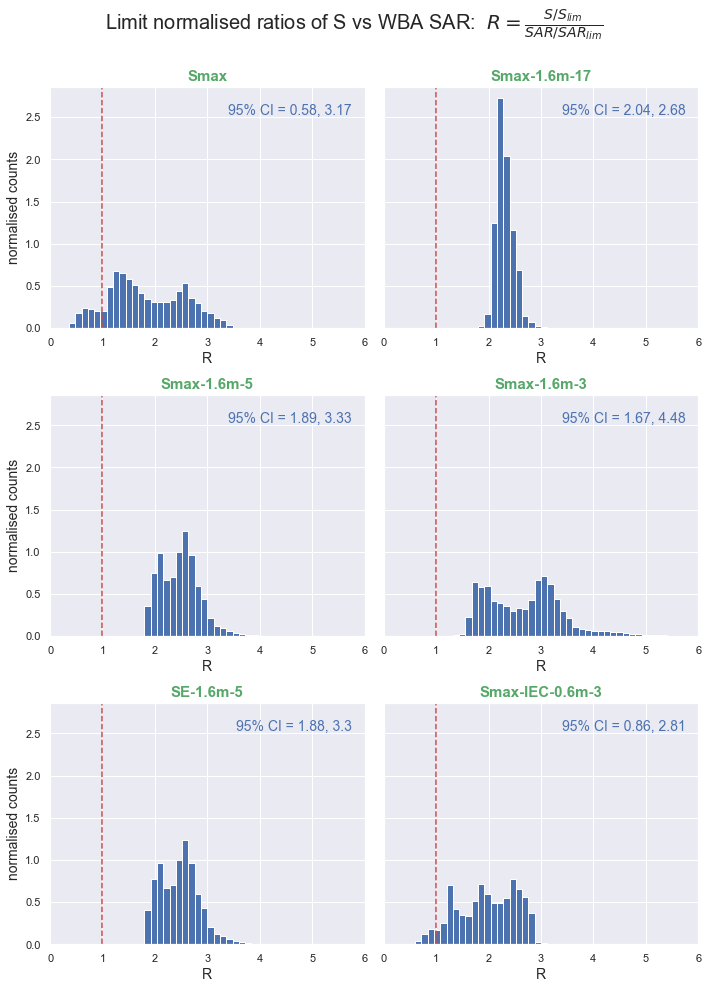

In [84]:
# R histograms for Slist with outant box filter 0.1m from antenna surface
offset = 0.667  # distance offset of two lambda from surface of antenna box
mask = R.sf('outant',offset=offset).mask
histR(Slist,dB=False,cols=2,mask=mask)

plt.savefig(plotdir + 'R histogram 2lambda outant.png', dpi=150)

In [85]:
dtlist = [col for col in R.S.columns if "compliance" in col and "dB" not in col]
R.S.loc[mask,dtlist].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Smax SARwbi compliance ratio,681249.0,1.83,0.71,0.06,1.29,1.72,2.46,5.52
Smax-1.6m-17 SARwbi compliance ratio,681249.0,2.33,8.07,1.75,2.19,2.28,2.40,5424.97
Smax-1.6m-5 SARwbi compliance ratio,681249.0,2.53,25.05,0.94,2.16,2.49,2.71,16810.87
Smax-1.6m-3 SARwbi compliance ratio,681249.0,2.79,41.75,0.72,2.04,2.74,3.16,28017.54
SE-1.6m-5 SARwbi compliance ratio,681249.0,2.52,25.05,0.84,2.15,2.48,2.70,16810.87
Smax-IEC-0.6m-3 SARwbi compliance ratio,681249.0,1.96,0.56,0.09,1.50,1.98,2.46,5.01


In [86]:
# Check that outant points have been removed from assessment grid
reload(RFcalcUC)
RFcalcUC.show_grid_points(R.S[mask], fields=['Smax'], hman=None,
                          axv=(True,True,False),antcolor='yellow',ycut=True)

#### dB R histograms with outant box filter
distance offset of $2\lambda$ from surface of antenna box

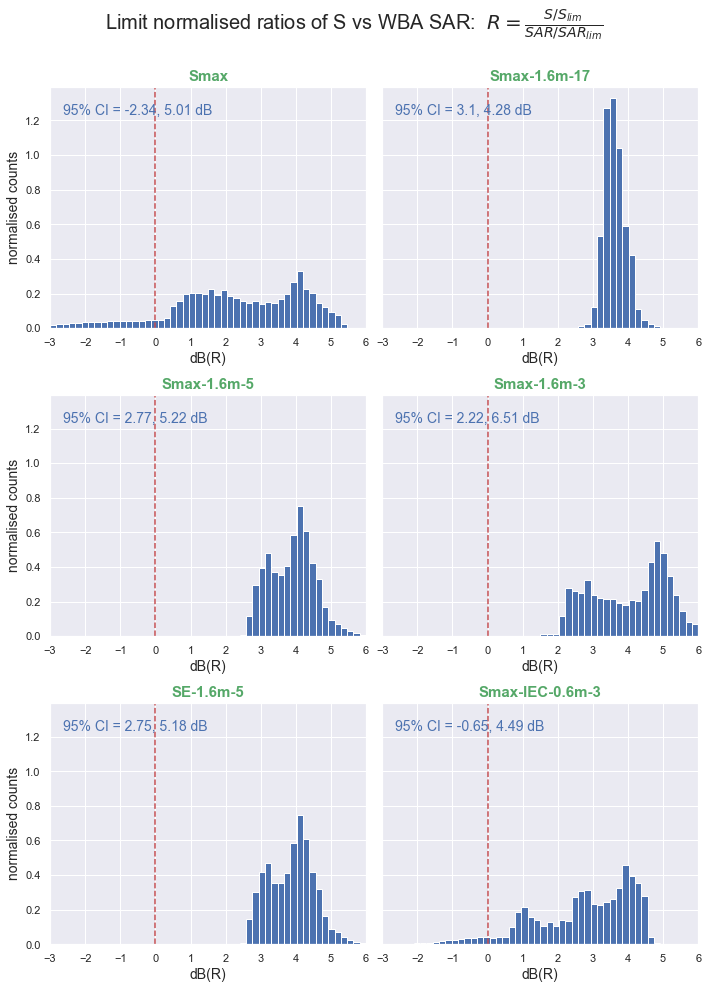

In [87]:
# R histograms for Slist with outant box filter 0.1m from antenna surface
offset = 0.667  # distance offset of two lambda from surface of antenna box
mask = R.sf('outant',offset=offset).mask
histR(Slist,dB=True,cols=2,mask=mask)

plt.savefig(plotdir + 'dB(R) histogram 2lambda outant.png', dpi=150)

In [88]:
dBdtlist = [col for col in R.S.columns if "compliance" in col and "dB" in col]
R.S.loc[mask,dBdtlist].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
dB Smax SARwbi compliance ratio,681249.0,2.24,1.92,-12.12,1.09,2.35,3.91,7.42
dB Smax-1.6m-17 SARwbi compliance ratio,681249.0,3.62,0.33,2.43,3.40,3.58,3.81,37.34
dB Smax-1.6m-5 SARwbi compliance ratio,681249.0,3.89,0.67,-0.27,3.34,3.96,4.33,42.26
dB Smax-1.6m-3 SARwbi compliance ratio,681249.0,4.16,1.20,-1.45,3.09,4.38,5.00,44.47
dB SE-1.6m-5 SARwbi compliance ratio,681249.0,3.88,0.67,-0.77,3.32,3.94,4.32,42.26
dB Smax-IEC-0.6m-3 SARwbi compliance ratio,681249.0,2.72,1.41,-10.51,1.76,2.98,3.91,7.00


#### Kolmogorov-Smirnov test for outant points

In [78]:
ks_table = R.S.loc[mask,dtlist+dBdtlist].dropna().agg(kstest, cdf='norm').T
ks_table.columns = ['KS statistic','p-value']
ks_table

,KS statistic,p-value
Smax SARwbi compliance ratio,0.726915,0.0
Smax-1.6m-17 SARwbi compliance ratio,0.968990,0.0
Smax-1.6m-5 SARwbi compliance ratio,0.963895,0.0
Smax-1.6m-3 SARwbi compliance ratio,0.939266,0.0
SE-1.6m-5 SARwbi compliance ratio,0.963016,0.0
Smax-IEC-0.6m-3 SARwbi compliance ratio,0.800268,0.0
dB Smax SARwbi compliance ratio,0.613508,0.0
dB Smax-1.6m-17 SARwbi compliance ratio,0.995287,0.0
dB Smax-1.6m-5 SARwbi compliance ratio,0.994038,0.0
dB Smax-1.6m-3 SARwbi compliance ratio,0.973739,0.0


<u>Notes</u>:

+ The p value signifies the likelihood of the null hypothesis, i.e. that the distribution is normal
+ The p values are 0 because of the very large number of points (1,298,751) in the distributions
+ the KS statistic shows that the **dB(R)** distributions for the 1.6m spatial averages of S are marginally more normal than the **R** distributions as their KS statistics are marginally higher. 

### R vs r

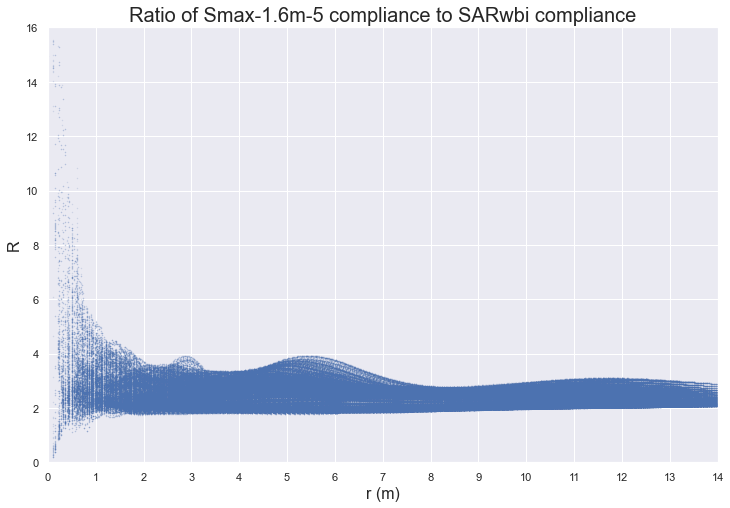

In [15]:
Ssa = 'Smax-1.6m-5 SARwbi compliance ratio'
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(x=R.S.r, y=R.S[Ssa],alpha=0.2,s=0.2);
ax.set_title(R.datatitles[Ssa],fontsize=20)
ax.set_xlabel('r (m)', fontsize=16)
ax.set_ylabel('R', fontsize=16)
ax.set_xlim((0,14))
ax.set_ylim((0,16))
ax.set_xticks(range(15))
fig.savefig(plotdir + f'R vs r scatter ({Ssa}).png')

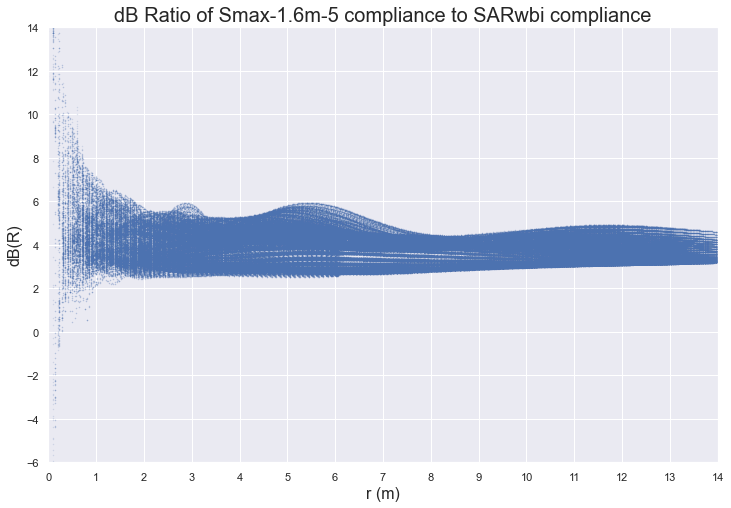

In [100]:
Ssa = 'dB Smax-1.6m-5 SARwbi compliance ratio'
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(x=R.S.r, y=R.S[Ssa],alpha=0.2,s=0.2);
ax.set_title(R.datatitles[Ssa],fontsize=20)
ax.set_xlabel('r (m)', fontsize=16)
ax.set_ylabel('dB(R)', fontsize=16)
ax.set_xlim((0,14))
ax.set_ylim((-6,14))
ax.set_xticks(range(15))
ax.set_yticks(range(-6,15,2))
fig.savefig(plotdir + f'dB(R) vs r scatter ({Ssa}).png')

In [21]:
Ssa = 'dB Smax-1.6m-5 SARwbi compliance ratio'
f = R.sf('((y==0) | (z==0)) & (y<=0) & (z>=0)')

R.msp(data=Ssa, f=f, mp=1, V=[-4, 12],
      nlabels=9, ncolors=8, ctitle=None, standard='RPS S-1 WB')

replacing y with S.y --> ((S.y==0) | (z==0)) & (S.y<=0) & (z>=0)
replacing z with S.z --> ((S.y==0) | (S.z==0)) & (S.y<=0) & (S.z>=0)
meval: ((S.y==0) | (S.z==0)) & (S.y<=0) & (S.z>=0)


## Scratch

In [41]:
def skewGrid():
    '''Show S and SAR grid points
    usage: .showgrids(S, SAR)
      S = flag to toggle S grid visibility (True/False)
    SAR = flag to toggle SAR grid visibility (True/False)
    hman = height of body model behind antenna in m
           If hman = None, then man model is not displayed
    avx = X,Y,Z axis visibility flags (True/False,True/False,True/False)
    '''
    # Make the grid
    x = [-0.8,-0.3,0.2, 0.5, 0.8, 1.3, 2, 3.2, 5, 7.3, 10, 13]
    y = [0, 0.3, 0.8, 1.6, 2.6, 4, 6]
    z = [-2,-1, 0, 1, 2]    
    xx, yy, zz = np.meshgrid(x,y,z)
    
    # create the Mayavi figure
    from mayavi import mlab
    fig = mlab.figure(1, size=(900,900), bgcolor=(0.3, 0.3, 0.3))
    mlab.clf()

    # draw the SAR grid popints
    mlab.points3d(xx,yy,zz,scale_factor=0.1,color=(1,1,0),opacity=1)   # SAR grid

    # Add the antenna box
    RFcalcUC.panelAntenna('yellow')

    # Draw the scene
    fig.scene.parallel_projection = True
    mlab.show()
    
skewGrid()

In [42]:
a = pd.Series([1,2,3,np.nan])
display(a)
a.mean()

0    1.0
1    2.0
2    3.0
3    NaN
dtype: float64

2.0

KstestResult(statistic=0.02695698665017554, pvalue=0.45373481183512343)

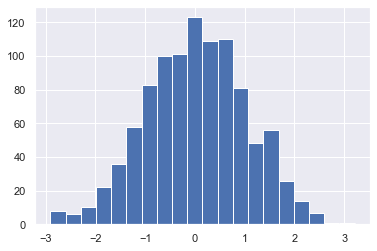

In [263]:
import numpy as np
from scipy import stats
np.random.seed(9)

my_data = stats.norm.rvs(size=1000)
plt.hist(my_data,bins=20);
stats.kstest(my_data, 'norm')

In [22]:
R.S['SARwbi'].dropna().size

689579